In [1]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 12.3 MB/s 
     |████████████████████████████████| 209 kB 57.9 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 112 kB 66.8 MB/s 
     |████████████████████████████████| 146 kB 64.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=4e073baa21fb729a07e3db3ccc82b7a055aad79ff24dc7a5f0798ffc57d3014c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 12.2 MB/s 
     |████████████████████████████████| 419 kB 67.1 

In [2]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)

drop_col = ['keyword']
res_data = data.drop(drop_col, axis=1)
# data['keyword'] = data['keyword'].str.replace("<"," ")
# res_data = data.copy()
res_data['date'] = pd.to_datetime(res_data['date'], format='%Y-%m-%d')
res_data = res_data.sort_values('date').reset_index(drop=True)
res_data['time_index'] = np.arange(len(data))
res_data['time_index'] = res_data['time_index'].astype(int)
res_data['dominant_topic'] = res_data['dominant_topic'].astype(str).astype("category")

# GroupNormalizer
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True,
    transformation="softplus"
)

res_data_columns = res_data.drop(columns=['date','market', 'time_index', 'kr_holiday','us_holiday','dayofweek','month','dominant_topic'], axis=1).columns
for n, i in enumerate(res_data_columns):
    # if n < 3:
    # print(i)
    globals()['scaled_{}'.format(i)] = gn.fit_transform(res_data[i], res_data, return_norm = True)
    res_data[i] = globals()['scaled_{}'.format(i)][0]

In [5]:
def objective(trial):

    cfg = { 'batch_size' : trial.suggest_categorical('batch_size', [128, 256]),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
            'log_interval' : trial.suggest_int('log_interval', 10, 50),
            'log_val_interval': trial.suggest_int('log_val_interval', 1, 10),
            'hidden_size' : trial.suggest_int('hidden_size', 8, 128),
            'hidden_continuous_size' : trial.suggest_int('hidden_continuous_size', 8, 128),
            'attention_head_size' : trial.suggest_int('attention_head_size', 1, 4),
            'dropout' : trial.suggest_int('dropout', 0.1, 0.3),
            'max_epochs' : trial.suggest_int('max_epochs', 500, 1500, 100), # 100, 1100, 200), 
            'limit_train_batches' : trial.suggest_int('limit_train_batches', 30, 30),
            'gpus' : trial.suggest_int('gpus', 1, 1),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 0.1),
            'save_model' : False,
            'output_size' : trial.suggest_loguniform('output_size',7,20)
            }


    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 60
    max_prediction_length = 20

    training_cutoff = res_data['time_index'].max() - max_prediction_length


    training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="trade_price",
            group_ids=["market"], # ["agency", "sku"],
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], # ["agency", "sku"],
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=['dayofweek', 'month','kr_holiday', 'us_holiday','dominant_topic'], #'kr_holiday','us_holiday'], #["special_days", "month"],
            # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            # time_varying_unknown_categoricals=["keyword"],     
            time_varying_unknown_reals=[
                "trade_price",
                "prev_closing_price",
                "candle_acc_trade_volume",
                "change_rate",
                "trade_price_log",
                "avg_trade_price_by_dow",
                "avg_trade_price_mo",
            ],
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    batch_size = cfg['batch_size'] 
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()

    print(f'mae_with_baseline : {mae_with_baseline}')

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = cfg['gpus'],
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  cfg['limit_train_batches'], # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )
        

    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate=cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size=cfg['hidden_continuous_size'],
        attention_head_size = cfg['attention_head_size'],
        dropout = cfg['dropout'],
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=cfg['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience= 4,
    )
    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    if cfg['save_model']:
        torch.save(TFT.state_dict(), "TFT_200612_01.pt")

    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)


    SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()

    # (actuals - predictions).abs().mean()

    return SMAPE

In [6]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=5)


[I 2022-06-12 02:11:05,474] A new study created in memory with name: no-name-eaf89922-89e5-487d-aa9e-15d904cd9f09
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/TFT/lightning_logs


mae_with_baseline : 0.45236268639564514
Number of parameters in network: 120.0k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 591   
3  | prescalers                         | ModuleDict                      | 720   
4  | static_variable_selection          | VariableSelectionNetwork        | 12.7 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 42.5 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-12 02:12:43,295] Trial 0 finished with value: 0.5966070294380188 and parameters: {'batch_size': 256, 'learning_rate': 0.0007186002312137623, 'log_interval': 20, 'log_val_interval': 7, 'hidden_size': 32, 'hidden_continuous_size': 30, 'attention_head_size': 1, 'dropout': 0, 'max_epochs': 1300, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.0019408406924132037, 'output_size': 8.834076384283694}. Best is trial 0 with value: 0.5966070294380188.
GPU available: True, used: True


tensor(0.5966)
mae_with_baseline : 0.45236268639564514


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 591   
3  | prescalers                         | ModuleDict                      | 2.4 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 25.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 86.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 18.5 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 5.4 K 
8  | sta

Number of parameters in network: 198.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-12 02:17:59,292] Trial 1 finished with value: 0.6236326694488525 and parameters: {'batch_size': 128, 'learning_rate': 0.03408380386029059, 'log_interval': 33, 'log_val_interval': 8, 'hidden_size': 36, 'hidden_continuous_size': 98, 'attention_head_size': 1, 'dropout': 0, 'max_epochs': 1300, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.00010808142767098134, 'output_size': 9.184230573852442}. Best is trial 0 with value: 0.5966070294380188.


tensor(0.6236)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 591   
3  | prescalers                         | ModuleDict                      | 2.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 111 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 344 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 77.2 K
7  | static_context_variable_selection  | GatedResidualNetw

mae_with_baseline : 0.45236268639564514
Number of parameters in network: 1179.2k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-12 02:23:34,033] Trial 2 finished with value: 0.6010729074478149 and parameters: {'batch_size': 256, 'learning_rate': 0.0007371615692870242, 'log_interval': 40, 'log_val_interval': 5, 'hidden_size': 113, 'hidden_continuous_size': 88, 'attention_head_size': 2, 'dropout': 0, 'max_epochs': 800, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.06115961107525032, 'output_size': 8.554431379556611}. Best is trial 0 with value: 0.5966070294380188.
GPU available: True, used: True


tensor(0.6011)
mae_with_baseline : 0.45236268639564514


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 591   
3  | prescalers                         | ModuleDict                      | 3.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 75.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 239 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 52.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 20.0 K
8  | sta

Number of parameters in network: 615.9k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-12 02:28:51,999] Trial 3 finished with value: 0.5385338068008423 and parameters: {'batch_size': 128, 'learning_rate': 0.0006548036351375021, 'log_interval': 25, 'log_val_interval': 5, 'hidden_size': 70, 'hidden_continuous_size': 127, 'attention_head_size': 3, 'dropout': 0, 'max_epochs': 1000, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.08454195009921096, 'output_size': 10.212557511419194}. Best is trial 3 with value: 0.5385338068008423.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


tensor(0.5385)
mae_with_baseline : 0.45236268639564514


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 591   
3  | prescalers                         | ModuleDict                      | 264   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 13.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 3.1 K 
8  | static_context_initial_hidden_lstm | GatedRe

Number of parameters in network: 59.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-12 02:33:52,152] Trial 4 finished with value: 0.4419006407260895 and parameters: {'batch_size': 128, 'learning_rate': 0.08101197043196366, 'log_interval': 31, 'log_val_interval': 1, 'hidden_size': 27, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'dropout': 0, 'max_epochs': 500, 'limit_train_batches': 30, 'gpus': 1, 'gradient_clip_val': 0.00024365904786420738, 'output_size': 17.517717864261993}. Best is trial 4 with value: 0.4419006407260895.


tensor(0.4419)


In [8]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_220612_01.pkl')
joblib.dump(study, '/content/tft_optuna.pkl')

['/content/tft_optuna.pkl']

In [14]:
optuna.visualization.plot_param_importances(study)
plt.show()

ZeroDivisionError: ignored

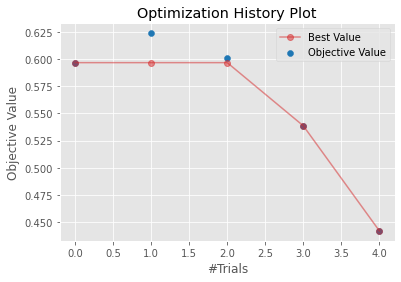



Number of finished trials:  5
Best trial:
  Value:  0.4419006407260895
  Params: 
    batch_size: 128
    learning_rate: 0.08101197043196366
    log_interval: 31
    log_val_interval: 1
    hidden_size: 27
    hidden_continuous_size: 11
    attention_head_size: 1
    dropout: 0
    max_epochs: 500
    limit_train_batches: 30
    gpus: 1
    gradient_clip_val: 0.00024365904786420738
    output_size: 17.517717864261993


In [10]:
# show best hyperparameters
# print(study.best_trial.params)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()
print("\n")


print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [11]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length


training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="trade_price",
            group_ids=["market"], # ["agency", "sku"],
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], # ["agency", "sku"],
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=["dayofweek", "month","kr_holiday", "us_holiday"], #'kr_holiday','us_holiday'], #["special_days", "month"],
            # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            time_varying_unknown_categoricals=["dominant_topic"],     
            time_varying_unknown_reals=[
                "trade_price",
                "prev_closing_price",
                "candle_acc_trade_volume",
                "change_rate",
                "trade_price_log",
                "avg_trade_price_by_dow",
                "avg_trade_price_mo",
            ],
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )


validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1,
    predict=True,
    stop_randomization=True
)


batch_size = study.best_params['batch_size']  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = SMAPE()(baseline_predictions, actuals)
print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')


# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs = study.best_params['max_epochs'],
    gpus = study.best_params['gpus'],
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  study.best_params['limit_train_batches'], # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger=logger
)
    

TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    attention_head_size = study.best_params['attention_head_size'],
    dropout = study.best_params['dropout'],
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval = study.best_params['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience = 4,
)
print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TFT.load_from_checkpoint(best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 591   
3  | prescalers                         | ModuleDict                      | 264   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 13.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.3 K 
7  | static_context_variable_selection  | GatedResidualNetw

mae_with_baseline : 0.45236268639564514
smape_with_baseline : 0.4222780764102936
Number of parameters in network: 59.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

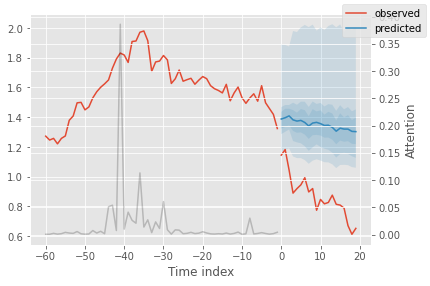

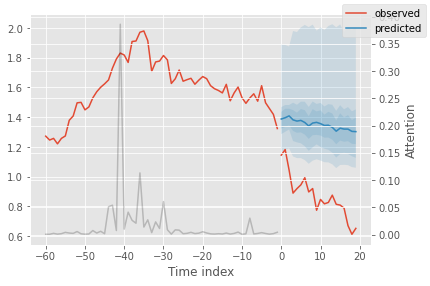

In [13]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)